In [1]:
#numpy and pandas for data manipulation
import numpy as np
import pandas as pd

#sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict

In [2]:
samples = pd.read_csv('data/application_train.csv')
# # Create an anomalous flag column
samples['DAYS_EMPLOYED_ANOM'] = samples["DAYS_EMPLOYED"] == 365243

# # # Replace the anomalous values with nan
samples['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Treating as outlier and removing
samples = samples[samples['CODE_GENDER'] != 'XNA']

train_label = samples['TARGET']
train_data = samples.drop(columns=['TARGET'])

correlations = samples.corr()

# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

# Drop highly correlated features
train_data = train_data.drop(train_data[to_drop], axis=1)

In [3]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_data:
    if train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_data[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_data[col])
            # Transform 
            train_data[col] = le.transform(train_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [4]:
# one-hot encoding of categorical variables
train_data = pd.get_dummies(train_data)

In [5]:
train_data['CREDIT_INCOME_PERCENT'] = train_data['AMT_CREDIT'] / train_data['AMT_INCOME_TOTAL']
train_data['ANNUITY_INCOME_PERCENT'] = train_data['AMT_ANNUITY'] / train_data['AMT_INCOME_TOTAL']
train_data['CREDIT_TERM'] = train_data['AMT_ANNUITY'] / train_data['AMT_CREDIT']
train_data['DAYS_EMPLOYED_PERCENT'] = train_data['DAYS_EMPLOYED'] / train_data['DAYS_BIRTH']

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train_data)

# Transform both training and testing data
train_data = imputer.transform(train_data)

# Repeat with the scaler
scaler.fit(train_data)
train_data = scaler.transform(train_data)

print('Training data shape: ', train_data.shape)

Training data shape:  (307507, 230)


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2)

In [8]:
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict

# Make the model with the specified regularization parameter

# 80-20 train-test case
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
log_reg = LogisticRegression(C = 0.001, max_iter=100, solver='sag', fit_intercept=True,
                             class_weight='balanced')
y_pred = cross_val_predict(estimator=log_reg , X=x_train, y=y_train, cv=kf, method='predict_proba')

from sklearn import metrics

# print(metrics.confusion_matrix(y_train, y_pred))
# print(metrics.classification_report(train_label ,y_pred))
# print("roc - {}".format(metrics.roc_auc_score(y_train, y_pred)))

In [12]:
y_pred

array([[0.6451454 , 0.3548546 ],
       [0.35189698, 0.64810302],
       [0.53853605, 0.46146395],
       ...,
       [0.5328944 , 0.4671056 ],
       [0.37136355, 0.62863645],
       [0.43653138, 0.56346862]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

tot_trees = [10000]
for tot_tree in tot_trees:
    kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    random_forest = RandomForestClassifier(n_estimators = tot_tree, class_weight='balanced', random_state = 50, verbose = 1, n_jobs = -1)
    y_pred = cross_val_predict(estimator=random_forest, X=x_train, y=y_train, cv=kf)
    print("Number of trees - {}  roc - {}".format(tot_tree,metrics.roc_auc_score(y_train, y_pred)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 61.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

In [20]:
make_prediction(arr):
    return [ for _y_predic]

0.3548545964872827

In [31]:
def classify(arr, threshold=0.5):
    return [1 if _y_pred[1]>=threshold else 0  for _y_pred in y_pred]
jpt = [1 if _y_pred[1]>=0.5 else 0  for _y_pred in y_pred]
print("roc - {}".format(metrics.roc_auc_score(y_train, jpt)))

roc - 0.6758773151208118


In [41]:
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict

# Make the model with the specified regularization parameter

# 80-20 train-test case
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
log_reg = LogisticRegression(C = 0.001, max_iter=100, solver='sag', fit_intercept=True,
                             class_weight='balanced')
y_pred = cross_val_predict(estimator=log_reg , X=x_train, y=y_train, cv=kf)
from sklearn import metrics

print(metrics.confusion_matrix(y_train, y_pred))
# print(metrics.classification_report(train_label ,y_pred))
print("roc - {}".format(metrics.roc_auc_score(y_train, y_pred)))

[[154276  71894]
 [  6527  13308]]
roc - 0.6765296407480921


In [44]:
final_log = LogisticRegression(C = 0.001, max_iter=100, solver='sag', fit_intercept=True,
                             class_weight='balanced')
final_log.fit(x_train, y_train)
test_pred = final_log.predict(x_test)
print(metrics.confusion_matrix(y_test, test_pred))
print("roc - {}".format(metrics.roc_auc_score(y_test, test_pred)))

[[38637 17875]
 [ 1679  3311]]
roc - 0.673611276204731


In [45]:
from sklearn.model_selection import StratifiedKFold

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_predict

# 80-20 train-test case
mlp_kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#mean of number of hidden nodes(1 layer is enough for) between input nodes and output nodes
total_hidden_nodes = int((2 + (len(samples.columns)-1))/2)
mlp = MLPClassifier(hidden_layer_sizes=(total_hidden_nodes-10,),activation='logistic', solver='sgd', 
                    batch_size=400, learning_rate_init=0.01, max_iter=200, alpha=0.0001)
y_pred = cross_val_predict(estimator=mlp , X=x_train, y=y_train, cv=mlp_kf)
from sklearn import metrics

print(metrics.confusion_matrix(y_train, y_pred))
# print(metrics.classification_report(train_label ,y_pred))
print("roc - {}".format(metrics.roc_auc_score(y_train, y_pred)))

[[226006    164]
 [ 19681    154]]
roc - 0.5035194675835113


In [46]:
final_mlp = MLPClassifier(hidden_layer_sizes=(total_hidden_nodes-10,),activation='logistic', solver='sgd', 
                    batch_size=400, learning_rate_init=0.01, max_iter=200, alpha=0.0001)
final_mlp.fit(x_train, y_train)
test_pred = final_mlp.predict(x_test)
print(metrics.confusion_matrix(y_test, test_pred))
print("roc - {}".format(metrics.roc_auc_score(y_test, test_pred)))

[[56490    22]
 [ 4972    18]]
roc - 0.5016089582903066


In [48]:
len(to_drop)

15

In [51]:
train_data.shape

(307507, 230)

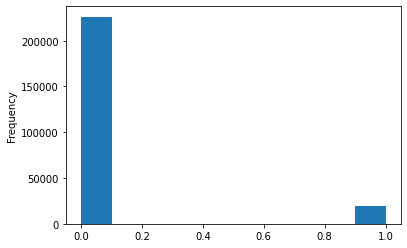

In [52]:
y_train.astype(int).plot.hist();

In [54]:
y_train.shape

(246005,)

In [55]:
y_test.shape



(61502,)